# Tools

In [3]:
%pip install --quiet -U langchain_groq langchain_core langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.1 MB/s eta 0:00:00


In [4]:
from langchain_groq import ChatGroq

In [6]:
from google.colab import userdata
apikey = userdata.get('GROQ_API_KEY')

In [7]:
llm = ChatGroq(model= 'llama-3.3-70b-versatile', temperature = 0, api_key=apikey)

In [8]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f499be31750>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f499bb77a50>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
llm.invoke('what is gen ai')

AIMessage(content='Gen AI, also known as Generative AI, is a type of artificial intelligence that focuses on generating new, original content, such as text, images, videos, music, or even code. It uses complex algorithms and machine learning models to create new data that is similar in style, structure, and quality to existing data.\n\nGen AI models are trained on large datasets, which enables them to learn patterns, relationships, and structures within the data. This training allows them to generate new content that is often indistinguishable from human-created content.\n\nSome common applications of Gen AI include:\n\n1. **Text generation**: Gen AI can generate human-like text, such as articles, stories, or even entire books.\n2. **Image and video generation**: Gen AI can create realistic images and videos, such as faces, objects, or scenes.\n3. **Music and audio generation**: Gen AI can generate music, sound effects, or even entire audio tracks.\n4. **Code generation**: Gen AI can g

In [10]:
def deposit_money(name:str, bank_account:int, amount:int) -> str:
  """Deposit money in bank account

  Args:
   name : Bank Account Holder Name
   bank_account : Bank account number
   amount : money to be deposit

   Returns:
   str : deposit status
   """
  return f'{amount} has been deposited in {name} Account'


In [11]:
llm_with_tools = llm.bind_tools([deposit_money])

In [12]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f499be31750>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f499bb77a50>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'deposit_money', 'description': 'Deposit money in bank account', 'parameters': {'properties': {'name': {'description': 'Bank Account Holder Name', 'type': 'string'}, 'bank_account': {'description': 'Bank account number', 'type': 'integer'}, 'amount': {'description': 'money to be deposit', 'type': 'integer'}}, 'required': ['name', 'bank_account', 'amount'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [13]:
from langchain_core.messages import HumanMessage

In [14]:
call = llm.invoke(
    [HumanMessage(content='depost $200 in zeeshan account. his account no is 12345', name = 'Zeeshan')]
)

In [15]:
call

AIMessage(content='I\'m not capable of directly accessing or modifying external bank accounts or financial systems. I\'m a text-based AI assistant, and I don\'t have the ability to perform financial transactions.\n\nHowever, I can guide you through the general process of depositing money into someone\'s account. To deposit $200 into Zeeshan\'s account, you would typically need to:\n\n1. Visit the bank\'s website or mobile app\n2. Log in to your own account\n3. Navigate to the "Transfer" or "Deposit" section\n4. Enter Zeeshan\'s account number (12345) and other required details\n5. Enter the amount you want to deposit ($200)\n6. Confirm the transaction and follow any additional prompts\n\nPlease note that you should only attempt to deposit money into someone\'s account if you have their explicit permission and are using a secure and legitimate banking system. Additionally, you should verify the account number and other details with Zeeshan to ensure accuracy.\n\nIf you have any further 

In [16]:
call = llm_with_tools.invoke(
    [HumanMessage(content='depost $200 in zeeshan account. his account no is 12345', name = 'Zeeshan')]
)

In [17]:
call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nckz', 'function': {'arguments': '{"name": "Zeeshan", "bank_account": 12345, "amount": 200}', 'name': 'deposit_money'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 265, 'total_tokens': 295, 'completion_time': 0.109090909, 'prompt_time': 0.015393088, 'queue_time': 0.7459533700000001, 'total_time': 0.124483997}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_5f849c5a0b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0cb3ebfa-5647-48ea-a380-8e714a014f31-0', tool_calls=[{'name': 'deposit_money', 'args': {'name': 'Zeeshan', 'bank_account': 12345, 'amount': 200}, 'id': 'call_nckz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 265, 'output_tokens': 30, 'total_tokens': 295})

# Graph Build

In [18]:
from typing_extensions import TypedDict

class State(TypedDict):
  messages:list

# tool call
def call_llm(state: State):
  messages = state['messages']
  call_response = llm_with_tools.invoke(messages)

  return {"messages" : [call_response]}

In [19]:
from langgraph.graph import StateGraph, START, END
builder: StateGraph = StateGraph(State)

#define node
builder.add_node('call_llm', call_llm)

#define edges
builder.add_edge(START,'call_llm')
builder.add_edge('call_llm', END)

#build graph
graph = builder.compile()

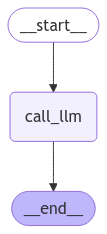

In [21]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
graph.invoke({'messages': [HumanMessage(content='depost $200 in zeeshan account. his account no is 12345', name = 'Zeeshan')]})

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jwxq', 'function': {'arguments': '{"name": "Zeeshan", "bank_account": 12345, "amount": 200}', 'name': 'deposit_money'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 265, 'total_tokens': 295, 'completion_time': 0.109090909, 'prompt_time': 0.016647417, 'queue_time': 0.8365580819999999, 'total_time': 0.125738326}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_0a4b7a8df3', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6c9ff650-7e72-4dca-9a26-f7bed7c11bc9-0', tool_calls=[{'name': 'deposit_money', 'args': {'name': 'Zeeshan', 'bank_account': 12345, 'amount': 200}, 'id': 'call_jwxq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 265, 'output_tokens': 30, 'total_tokens': 295})]}